Pre-class work

These notes work through the motivation behind testing a model we have seen before. Use the notes to refresh your memory of this particular model, make sure you understand the choice of test statistic used below, and write Python code to compute the p-value for the test statistic.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import stats
import numpy as np
%matplotlib inline

Model and dataset



In a previous class session, we modeled the dataset shown below using a normal likelihood with unknown mean and variance and a conjugate normal-inverse-gamma prior over the parameters.

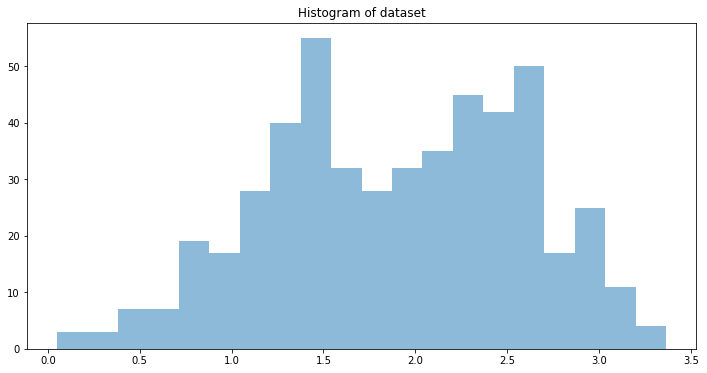

In [2]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
# Log-transform the data so we can model it using a normal likelihood.
data = np.log(np.loadtxt('hrtem.csv'))

plt.figure(figsize=(12, 6))
plt.hist(data, bins=20, alpha=0.5)
plt.title('Histogram of dataset')
plt.show()

In [3]:
mu_0 = 2.3
nu_0 = 0.1
alpha_0 = 2
beta_0 = 5

print('Posterior hyperparameters:')
print('  μ₀ =', mu_0)
print('  ν₀ =', nu_0)
print('  α₀ =', alpha_0)
print('  β₀ =', beta_0)

Posterior hyperparameters:
  μ₀ = 2.3
  ν₀ = 0.1
  α₀ = 2
  β₀ = 5


In [4]:
# Sufficient statistics of the data
s0 = len(data)
s1 = sum(data)
s2 = sum(data ** 2)

# Posterior parameters
mu_1 = (nu_0 * mu_0 + s1) / (nu_0 + s0)
nu_1 = nu_0 + s0
alpha_1 = alpha_0 + s0 / 2
beta_1 = beta_0 + s2/2 - s1**2 / (2*s0) + s0*nu_0/(nu_1 + s0) * (s1/s0 - mu_0)**2/2

print('Posterior hyperparameters:')
print('  μ₁ =', mu_1)
print('  ν₁ =', nu_1)
print('  α₁ =', alpha_1)
print('  β₁ =', beta_1)

Posterior hyperparameters:
  μ₁ = 1.892401480510831
  ν₁ = 500.1
  α₁ = 252.0
  β₁ = 124.45079772182757


One criticism against this model is that it looks like the data distribution might be bimodal rather than unimodal, which would make a normal likelihood inappropriate. Let’s design a test statistic to check whether this bimodal appearance is really statistically significant or not.

Our test statistic is the proportion of data values that lie within one standard deviation of the mean of the dataset.

So, given a dataset $\{y_i\}$, we compute the sample mean $\bar{\mu}$ and sample standard deviation $\bar{\sigma}$. We then count the proportion of data values that lie in the range $[\bar{\mu}-\bar{\sigma}, \bar{\mu}+\bar{\sigma}]$.

In [6]:
def test_statistic(data):
    mu = np.mean(data)  # sample mean
    sigma = np.std(data, ddof=1)  # sample standard deviation
    return np.mean((data > mu - sigma) & (data < mu + sigma))

For a normally distributed dataset, we expect approximately 68% of the data to lie within one standard deviation of the mean. For a bimodal dataset with equal probability mass in the two modes, we expect far fewer values to lie in this range since there is a gap between the modes.

Here is an example to demonstrate why.

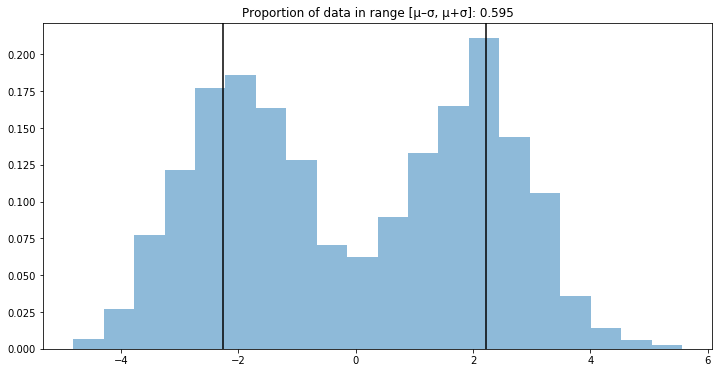

In [7]:
# Generate samples from a mixture of two normal distributions
N = 1000
x = np.concatenate((stats.norm.rvs(loc=-2, scale=1, size=1000), stats.norm.rvs(loc=2, scale=1, size=1000)))
mu = np.mean(x)  # sample mean
sigma = np.std(x, ddof=1)  # sample standard deviation

plt.figure(figsize=(12, 6))
plt.hist(x, bins=20, alpha=0.5, density=True)
plt.axvline(mu - sigma, color='black')
plt.axvline(mu + sigma, color='black')
plt.title('Proportion of data in range [μ–σ, μ+σ]: %.3f' % test_statistic(x))
plt.show()

The black lines show the mean plus and minus one standard deviation.

In this case, 60.2% of the data lie between the black lines.

If we apply this test statistic to the original dataset, we get the following.

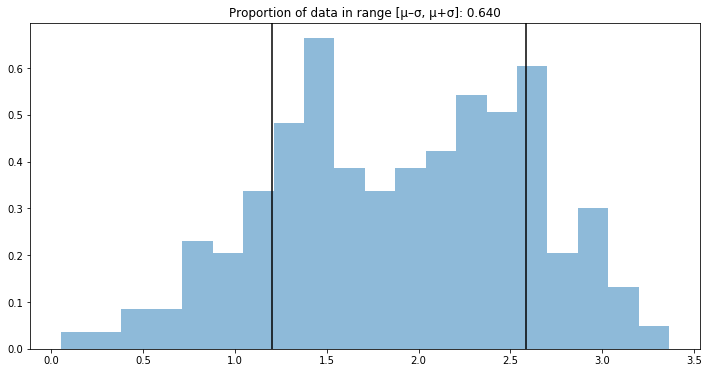

In [8]:
mu = np.mean(data)
sigma = np.std(data)

plt.figure(figsize=(12, 6))
plt.hist(data, bins=20, alpha=0.5, density=True)
plt.axvline(mu - sigma, color='black')
plt.axvline(mu + sigma, color='black')
plt.title('Proportion of data in range [μ–σ, μ+σ]: %.3f' % test_statistic(data))
plt.show()

So the test statistic evaluated on the real dataset is 0.640. But is this statistically significantly different from the expected value, which is 0.680 if we assume normally distributed data in our model?

We can only answer this question by comparing the test statistic for the real dataset (0.640) to the test statistic on replicated data from the posterior predictive distribution of our model.

In [9]:
#SAMPLE
def norminvgamma_rvs(mu, nu, alpha, beta, size=1):
    '''
    Generate n samples from the normal-inverse-gamma distribution. This function
    returns a (size x 2) matrix where each row contains a sample, (x, sigma2).
    '''
    sigma2 = stats.invgamma.rvs(a=alpha, scale=beta, size=size)  # Sample sigma^2 from the inverse-gamma
    x = stats.norm.rvs(loc=mu, scale=np.sqrt(sigma2 / nu), size=size)  # Sample x from the normal
    return np.vstack((x, sigma2)).transpose()


#TEST-STATISTIC
test_stat = []

for i in range(1000):
    sampling =  (norminvgamma_rvs(mu_1, nu_1, alpha_1, beta_1))
    print (sampling)
     
    mu = sampling[0][0] # sample mean
    sigma = sampling[0][1] # sample standard deviation
    test_stat.append(np.mean((data > mu - sigma) & (data < mu + sigma)))
    print (np.mean((data > mu - sigma) & (data < mu + sigma)))
    print (" ")

[[1.95480225 0.540276  ]]
0.496
 
[[1.91160231 0.47648385]]
0.422
 
[[1.90980054 0.44488346]]
0.378
 
[[1.93585817 0.49769565]]
0.446
 
[[1.90724217 0.51599079]]
0.474
 
[[1.90445056 0.49367592]]
0.45
 
[[1.832185   0.50585574]]
0.462
 
[[1.88038829 0.54661084]]
0.508
 
[[1.87860157 0.47674999]]
0.424
 
[[1.85448748 0.48666507]]
0.448
 
[[1.92579893 0.50253697]]
0.466
 
[[1.8880591  0.46942182]]
0.422
 
[[1.953034  0.5095552]]
0.458
 
[[1.91139849 0.5699685 ]]
0.538
 
[[1.84120263 0.50200768]]
0.462
 
[[1.85270727 0.45099485]]
0.406
 
[[1.88133784 0.52699865]]
0.488
 
[[1.91627312 0.5125667 ]]
0.468
 
[[1.86246765 0.46056398]]
0.418
 
[[1.87812709 0.44856015]]
0.406
 
[[1.86755019 0.51233221]]
0.47
 
[[1.86365305 0.50367197]]
0.462
 
[[1.86099868 0.50040891]]
0.46
 
[[1.87087963 0.5059952 ]]
0.464
 
[[1.90687502 0.48051815]]
0.434
 
[[1.91754771 0.45723977]]
0.396
 
[[1.88347417 0.4917157 ]]
0.44
 
[[1.85330074 0.48286817]]
0.446
 
[[1.89314183 0.46454457]]
0.412
 
[[1.90186865 0.43604

(array([ 20.,  54., 119., 196., 255., 192., 103.,  40.,  19.,   2.]),
 array([0.352 , 0.3738, 0.3956, 0.4174, 0.4392, 0.461 , 0.4828, 0.5046,
        0.5264, 0.5482, 0.57  ]),
 <a list of 10 Patch objects>)

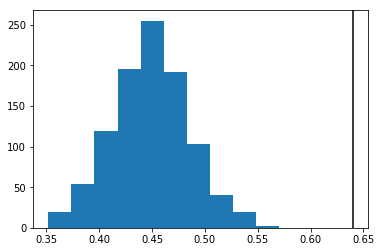

In [10]:
#Histogram of the test statistic
test_stat
plt.axvline(0.64, color='black')
plt.hist(test_stat)

In [12]:
samples = norminvgamma_rvs(mu_1, nu_1, alpha_1,beta_1, size = 1000)
print (samples)

[[1.92078335 0.417362  ]
 [1.9077713  0.46251984]
 [1.88629283 0.51957132]
 ...
 [1.90071022 0.49532469]
 [1.89768731 0.51492585]
 [1.89438049 0.44678899]]


In [13]:
t_s = []

for i in range(1000):
    data = stats.norm.rvs(loc=samples[i][0], scale=samples[i][1], size=1000)
    t_s.append(test_statistic(data)) 

In [14]:
print (sum(test_stat)/len(test_stat))
print (np.std(test_stat))

0.4482260000000009
0.03616585301081671


In [15]:
zscore = ( 0.64 - 0.4486200000000005 ) / 0.03677389835195611
prob = 1 - stats.norm.cdf(zscore)
prob 
#p- value = 0.000000097, which is smaller than the 0.05 
#I reject the null hypothesis, and we say the result is statistically significant

9.739881501324987e-08